In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load data
df = pd.read_csv("customer_support_tickets.csv")


# Preview dataset
print("Shape:", df.shape)
print("Columns:", df.columns.tolist())
print(df.head())

Shape: (8469, 17)
Columns: ['Ticket ID', 'Customer Name', 'Customer Email', 'Customer Age', 'Customer Gender', 'Product Purchased', 'Date of Purchase', 'Ticket Type', 'Ticket Subject', 'Ticket Description', 'Ticket Status', 'Resolution', 'Ticket Priority', 'Ticket Channel', 'First Response Time', 'Time to Resolution', 'Customer Satisfaction Rating']
   Ticket ID        Customer Name              Customer Email  Customer Age  \
0          1        Marisa Obrien  carrollallison@example.com            32   
1          2         Jessica Rios    clarkeashley@example.com            42   
2          3  Christopher Robbins   gonzalestracy@example.com            48   
3          4     Christina Dillon    bradleyolson@example.org            27   
4          5    Alexander Carroll     bradleymark@example.com            67   

  Customer Gender Product Purchased Date of Purchase      Ticket Type  \
0           Other        GoPro Hero       2021-03-22  Technical issue   
1          Female       LG 

In [2]:
df.head

<bound method NDFrame.head of       Ticket ID        Customer Name              Customer Email  \
0             1        Marisa Obrien  carrollallison@example.com   
1             2         Jessica Rios    clarkeashley@example.com   
2             3  Christopher Robbins   gonzalestracy@example.com   
3             4     Christina Dillon    bradleyolson@example.org   
4             5    Alexander Carroll     bradleymark@example.com   
...         ...                  ...                         ...   
8464       8465           David Todd          adam28@example.net   
8465       8466           Lori Davis       russell68@example.com   
8466       8467      Michelle Kelley        ashley83@example.org   
8467       8468     Steven Rodriguez         fpowell@example.org   
8468       8469      Steven Davis MD          lori20@example.net   

      Customer Age Customer Gender       Product Purchased Date of Purchase  \
0               32           Other              GoPro Hero       2021-03-2

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import LabelEncoder

# Step 1: Load Data
df = pd.read_csv('customer_support_tickets.csv')
df.columns = df.columns.str.strip().str.lower()

# Step 2: Handle Missing Values (basic)
df['customer satisfaction rating'] = df['customer satisfaction rating'].fillna(0)
df = df.dropna(subset=['customer satisfaction rating'])  # Keep only rated tickets

# Step 3: Feature Selection
# Drop non-informative columns (like description or email)
df_model = df.drop(columns=[
    'ticket id', 'customer name', 'customer email', 'ticket subject',
    'ticket description', 'resolution', 'date of purchase'  # could be reused later
])

# Step 4: Encode Categorical Variables
categorical_cols = df_model.select_dtypes(include='object').columns
label_encoders = {}

for col in categorical_cols:
    le = LabelEncoder()
    df_model[col] = le.fit_transform(df_model[col].astype(str))
    label_encoders[col] = le

# Step 5: Define Features and Target
X = df_model.drop(columns=['customer satisfaction rating'])
y = df_model['customer satisfaction rating'].astype(int)

# Step 6: Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 7: Model Training
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# Step 8: Predictions
y_pred = model.predict(X_test)

# Step 9: Evaluation
print("🔍 Classification Report:")
print(classification_report(y_test, y_pred))

print("✅ Accuracy Score:", accuracy_score(y_test, y_pred))


🔍 Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1120
           1       0.21      0.21      0.21       115
           2       0.20      0.22      0.21       109
           3       0.20      0.20      0.20       117
           4       0.26      0.24      0.25       126
           5       0.18      0.18      0.18       107

    accuracy                           0.73      1694
   macro avg       0.34      0.34      0.34      1694
weighted avg       0.73      0.73      0.73      1694

✅ Accuracy Score: 0.731995277449823


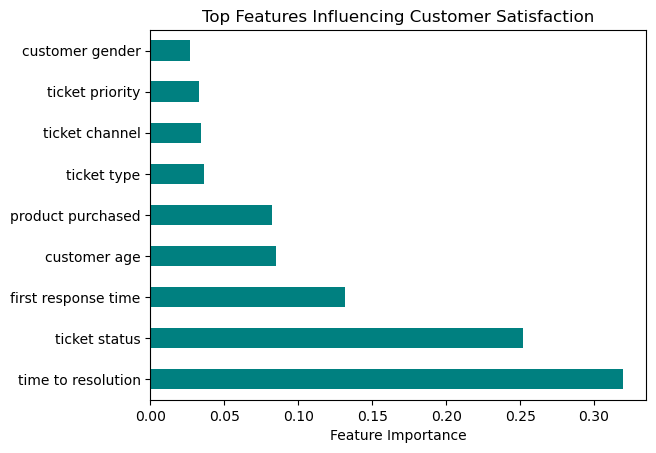

In [4]:
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(10).plot(kind='barh', color='teal')
plt.title("Top Features Influencing Customer Satisfaction")
plt.xlabel("Feature Importance")
plt.show()


In [5]:
import pandas as pd
import joblib
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
import numpy as np

# Load dataset
df = pd.read_csv('customer_support_tickets.csv')
df.columns = df.columns.str.strip().str.lower()

# Drop rows without rating
df = df.dropna(subset=['customer satisfaction rating'])
df['customer satisfaction rating'] = df['customer satisfaction rating'].astype(int)

# Convert date columns to datetime if necessary
df['first response time'] = pd.to_datetime(df['first response time'], errors='coerce')
df['time to resolution'] = pd.to_datetime(df['time to resolution'], errors='coerce')

# Convert to hours (or minutes if preferred)
min_date = df['first response time'].min()
df['first response time (hrs)'] = (df['first response time'] - min_date).dt.total_seconds() / 3600

min_date2 = df['time to resolution'].min()
df['time to resolution (hrs)'] = (df['time to resolution'] - min_date2).dt.total_seconds() / 3600

# Drop original time columns
df.drop(columns=['first response time', 'time to resolution'], inplace=True)

# Fill missing ticket description
df['ticket description'] = df['ticket description'].fillna('No description')

# Drop date of purchase if exists
df.drop(columns=[col for col in ['date of purchase'] if col in df.columns], inplace=True)

# Categorical and numeric columns
text_feature = 'ticket description'
categorical_features = [
    'customer gender', 'product purchased', 'ticket type',
    'ticket status', 'ticket priority', 'ticket channel'
]
numerical_features = ['customer age', 'first response time (hrs)', 'time to resolution (hrs)']

# Fill missing in categorical
for col in categorical_features:
    df[col] = df[col].fillna('Unknown')

# Train/test split
X = df[[text_feature] + categorical_features + numerical_features]
y = df['customer satisfaction rating']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Preprocessing pipeline
preprocessor = ColumnTransformer(transformers=[
    ('text', TfidfVectorizer(max_features=100), text_feature),
    ('cat', Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('encoder', OneHotEncoder(handle_unknown='ignore'))
    ]), categorical_features),
    ('num', Pipeline([
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler())
    ]), numerical_features)
])

# Final pipeline
pipeline = Pipeline([
    ('preprocessing', preprocessor),
    ('model', RandomForestClassifier(random_state=42))
])

# Fit and save
pipeline.fit(X_train, y_train)
joblib.dump(pipeline, 'customer_satisfaction_model.pkl')
print("✅ Model retrained and saved as 'customer_satisfaction_model.pkl'")


✅ Model retrained and saved as 'customer_satisfaction_model.pkl'


In [6]:
import pandas as pd
import joblib

# Load model
model = joblib.load("customer_satisfaction_model.pkl")

# Prediction function
def predict_satisfaction(ticket_description, gender, product, ticket_type,
                         status, priority, channel, age,
                         response_time_hrs, resolution_time_hrs):
    
    # Input format MUST match training feature names
    input_data = pd.DataFrame([{
        'ticket description': ticket_description,
        'customer gender': gender,
        'product purchased': product,
        'ticket type': ticket_type,
        'ticket status': status,
        'ticket priority': priority,
        'ticket channel': channel,
        'customer age': age,
        'first response time (hrs)': response_time_hrs,
        'time to resolution (hrs)': resolution_time_hrs
    }])
    
    # Predict
    predicted_rating = model.predict(input_data)[0]
    return int(predicted_rating)


In [7]:
rating = predict_satisfaction(
    ticket_description="I'm facing a problem with my Dell XPS. The Dell XPS is not turning on. It was working fine until yesterday, but now it doesn't respond.1.8.3 I really I'm using the original charger that came with my {product_purchased}, but it's not charging properly.",
    gender="Other",
    product="Dell XPS",
    ticket_type="Technical Issue",
    status="Closed",
    priority="Low",
    channel="Social media",
    age=48,
    response_time_hrs=11.14,
    resolution_time_hrs=18.5
)

print(f"🎯 Predicted Customer Satisfaction Rating: {rating} / 5")


🎯 Predicted Customer Satisfaction Rating: 3 / 5
